In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from tensorflow.keras.applications import EfficientNetB0
from keras.layers import GlobalAveragePooling2D,Dropout,Dense
from keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,TensorBoard,ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display,clear_output
import ipywidgets as widges
import io

In [2]:
labels=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
X_train = []
y_train = []
image_size=150
for i in labels:
    folderPath = os.path.join(r'/Users/saikeerthana/Downloads/Alzheimer_sDataset','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img= cv2.imread(os.path.join(folderPath,j))
        if img is not None:
            img =cv2.resize(img,(image_size,image_size))
            X_train.append(img)
            y_train.append(i)
for i in labels:
    folderPath = os.path.join(r'/Users/saikeerthana/Downloads/Alzheimer_sDataset','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img= cv2.imread(os.path.join(folderPath,j))
        if img is not None:
            img =cv2.resize(img,(image_size,image_size))
            X_train.append(img)
            y_train.append(i)

100%|███████████████████████████████████████| 448/448 [00:00<00:00, 3192.09it/s]


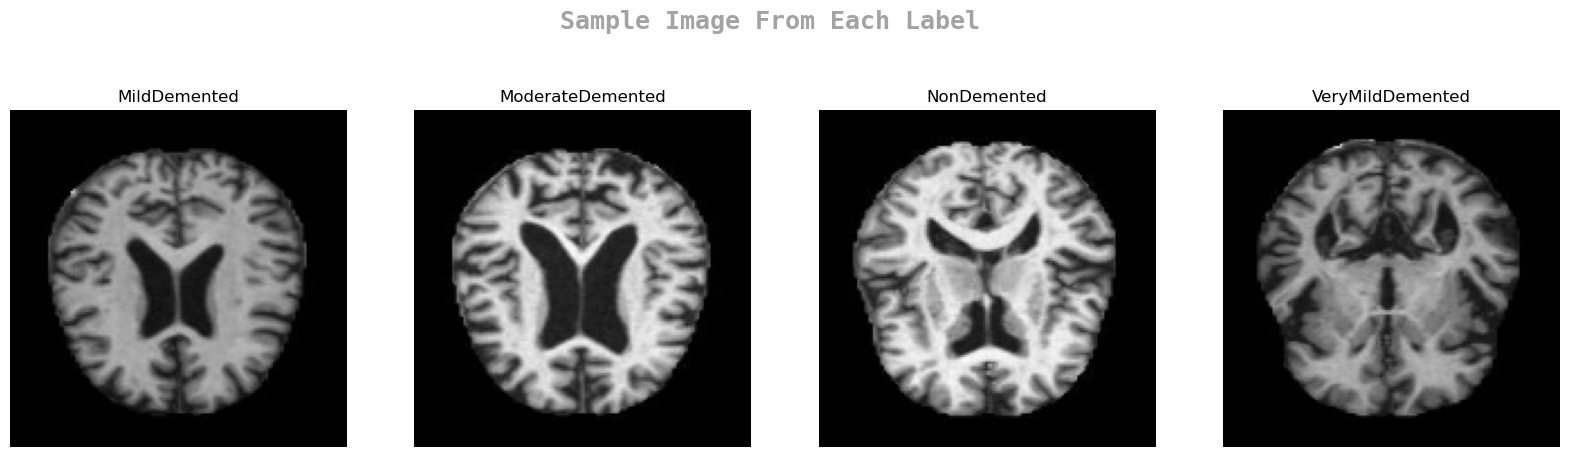

In [3]:
X_train = np.array(X_train)
y_train = np.array(y_train)
colors_dark = ['#28527a', '#8c8c8c', '#138a36', '#d63230']

k=0
fig, ax=plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True:
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1
#print(y_train[:60])

In [4]:
X_train,y_train=shuffle(X_train,y_train, random_state=101)
X_train.shape

(6400, 150, 150, 3)

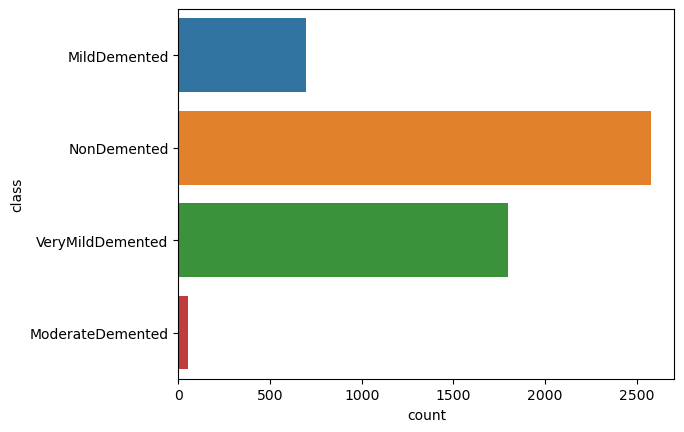

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert y_train to a Pandas DataFrame
y_train_df = pd.DataFrame({'class': y_train})
#print(y_train_df)
# Plot the count distribution using Seaborn
sns.countplot(y='class', data=y_train_df)

# Show the plot
plt.show()


In [6]:
labels=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

y_train_new= []
for i in y_train:
    try:
        y_train_new.append(labels.index(i))
        
    except ValueError:
        print("Invalid label:", i)
    
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new=[]
for i in y_test:
    try:
        y_test_new.append(labels.index(i))
    except ValueError:
        print("Invalid label:", i)
y_test=y_test_new
y_test=tf.keras.utils.to_categorical(y_test)

In [7]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.2 MB/s eta 0:00:00


In [8]:
from efficientnet.tfkeras import EfficientNetB0

In [9]:
effnet= EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
model=effnet.output
model= tf.keras.layers.GlobalAveragePooling2D()(model)
# model=tf.keras.layers.Flatten()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model=tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs=model)
model.summary()

16804768/16804768 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 75, 75, 32)           128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  

 block2b_expand_bn (BatchNo  (None, 38, 38, 144)          576       ['block2b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block2b_expand_activation   (None, 38, 38, 144)          0         ['block2b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block2b_dwconv (DepthwiseC  (None, 38, 38, 144)          1296      ['block2b_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block2b_bn (BatchNormaliza  (None, 38, 38, 144)          576       ['block2b_dwconv[0][0]']      
 tion)    

 block3b_expand_activation   (None, 19, 19, 240)          0         ['block3b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block3b_dwconv (DepthwiseC  (None, 19, 19, 240)          6000      ['block3b_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block3b_bn (BatchNormaliza  (None, 19, 19, 240)          960       ['block3b_dwconv[0][0]']      
 tion)                                                                                            
                                                                                                  
 block3b_activation (Activa  (None, 19, 19, 240)          0         ['block3b_bn[0][0]']          
 tion)    

 block4b_dwconv (DepthwiseC  (None, 10, 10, 480)          4320      ['block4b_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block4b_bn (BatchNormaliza  (None, 10, 10, 480)          1920      ['block4b_dwconv[0][0]']      
 tion)                                                                                            
                                                                                                  
 block4b_activation (Activa  (None, 10, 10, 480)          0         ['block4b_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block4b_se_squeeze (Global  (None, 480)                  0         ['block4b_activation[0][0]']  
 AveragePo

 block5a_expand_activation   (None, 10, 10, 480)          0         ['block5a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block5a_dwconv (DepthwiseC  (None, 10, 10, 480)          12000     ['block5a_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block5a_bn (BatchNormaliza  (None, 10, 10, 480)          1920      ['block5a_dwconv[0][0]']      
 tion)                                                                                            
                                                                                                  
 block5a_activation (Activa  (None, 10, 10, 480)          0         ['block5a_bn[0][0]']          
 tion)    

 block5c_dwconv (DepthwiseC  (None, 10, 10, 672)          16800     ['block5c_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block5c_bn (BatchNormaliza  (None, 10, 10, 672)          2688      ['block5c_dwconv[0][0]']      
 tion)                                                                                            
                                                                                                  
 block5c_activation (Activa  (None, 10, 10, 672)          0         ['block5c_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block5c_se_squeeze (Global  (None, 672)                  0         ['block5c_activation[0][0]']  
 AveragePo

 block6b_bn (BatchNormaliza  (None, 5, 5, 1152)           4608      ['block6b_dwconv[0][0]']      
 tion)                                                                                            
                                                                                                  
 block6b_activation (Activa  (None, 5, 5, 1152)           0         ['block6b_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block6b_se_squeeze (Global  (None, 1152)                 0         ['block6b_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6b_se_reshape (Reshap  (None, 1, 1, 1152)           0         ['block6b_se_squeeze[0][0]']  
 e)       

 block6d_dwconv (DepthwiseC  (None, 5, 5, 1152)           28800     ['block6d_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block6d_bn (BatchNormaliza  (None, 5, 5, 1152)           4608      ['block6d_dwconv[0][0]']      
 tion)                                                                                            
                                                                                                  
 block6d_activation (Activa  (None, 5, 5, 1152)           0         ['block6d_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block6d_se_squeeze (Global  (None, 1152)                 0         ['block6d_activation[0][0]']  
 AveragePo

                                                                    0]']                          
                                                                                                  
 dense (Dense)               (None, 4)                    5124      ['dropout[0][0]']             
                                                                                                  
Total params: 4054688 (15.47 MB)
Trainable params: 4012672 (15.31 MB)
Non-trainable params: 42016 (164.12 KB)
__________________________________________________________________________________________________


In [10]:
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])


In [11]:
reduce_lr=ReduceLROnPlateau(monitor='val_accuracy',factor=0.2,patience=2,min_delta= 0.001,mode='auto',verbose=1)

tensorboard=TensorBoard(log_dir='logs')
checkpoint=ModelCheckpoint("alzheimers-dataset-4-class-of images.h5", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)

In [12]:
datagen= ImageDataGenerator(
featurewise_center=True,
samplewise_center=False,
featurewise_std_normalization=True,
samplewise_std_normalization=False,
zca_whitening=False,
rotation_range=20,
zoom_range=0.2,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
horizontal_flip=True,
vertical_flip=True)
datagen.fit(X_train)
history= model.fit(X_train,y_train,validation_split=0.2, epochs=15, verbose=1, batch_size=32,callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15
128/128 [==============================] - ETA: 0s - loss: 0.8554 - accuracy: 0.6211
Epoch 1: val_accuracy improved from -inf to 0.61426, saving model to alzheimers-dataset-4-class-of images.h5


/Users/saikeerthana/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


128/128 [==============================] - 128s 979ms/step - loss: 0.8554 - accuracy: 0.6211 - val_loss: 0.9496 - val_accuracy: 0.6143 - lr: 0.0010
Epoch 2/15
128/128 [==============================] - ETA: 0s - loss: 0.4346 - accuracy: 0.8303
Epoch 2: val_accuracy improved from 0.61426 to 0.70801, saving model to alzheimers-dataset-4-class-of images.h5
128/128 [==============================] - 136s 1s/step - loss: 0.4346 - accuracy: 0.8303 - val_loss: 0.8130 - val_accuracy: 0.7080 - lr: 0.0010
Epoch 3/15
128/128 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.9036
Epoch 3: val_accuracy improved from 0.70801 to 0.81641, saving model to alzheimers-dataset-4-class-of images.h5
128/128 [==============================] - 131s 1s/step - loss: 0.2543 - accuracy: 0.9036 - val_loss: 0.5132 - val_accuracy: 0.8164 - lr: 0.0010
Epoch 4/15
128/128 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.9497
Epoch 4: val_accuracy improved from 0.81641 to 0.8

Text(0.5, 0, 'Epochs')

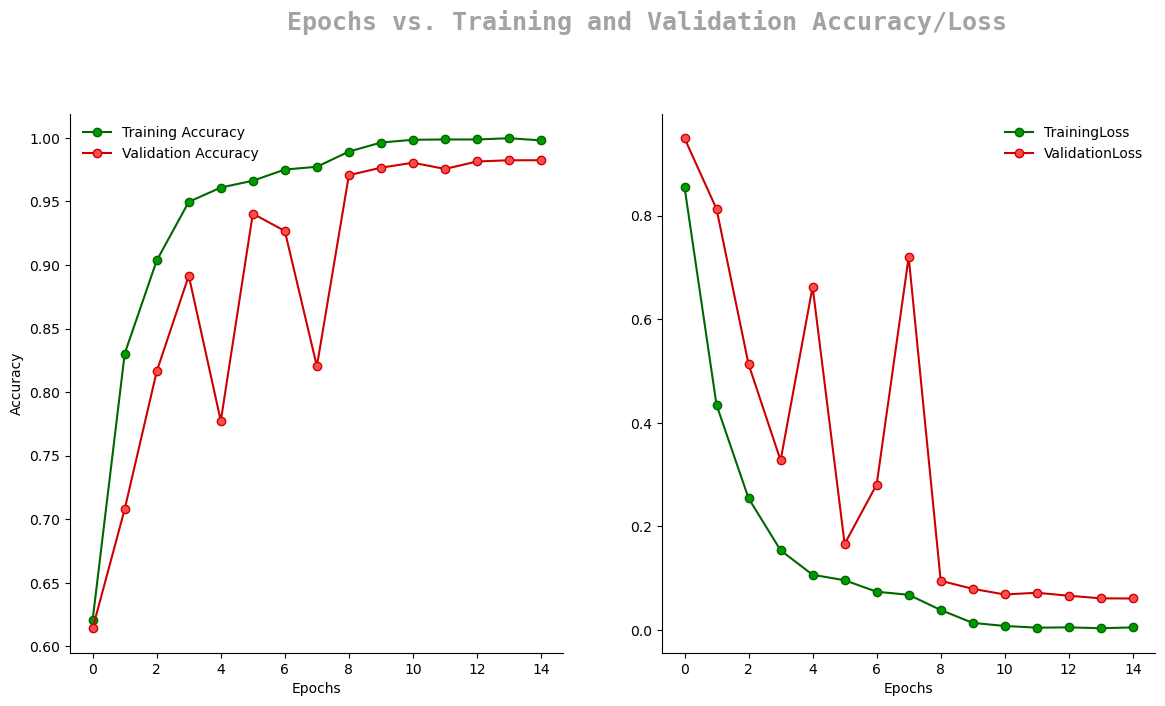

In [13]:
import warnings
warnings.filterwarnings('ignore')

epochs=[i for i in range(15)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss=history.history['loss'] 
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

colors_dark = ['#28527a', '#8c8c8c', '#138a36', '#d63230']
colors_green = ['#00FF00', '#00CC00', '#009900', '#006600']
colors_red = ['#ff0000','#a30000','#ff4d4d','#cc0000','#990000']
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)
sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
label='Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
sns.despine()
ax[1].plot(epochs,train_loss,marker='o',markerfacecolor=colors_green[2],color=colors_green[3],label='TrainingLoss')
ax[1].plot(epochs, val_loss,marker='o',markerfacecolor=colors_red[2],color=colors_red[3],label = 'ValidationLoss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
# ax[1].set_ylabel('Training & ValidationLoss')



40/40 [==============================] - 7s 162ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       198
           1       1.00      1.00      1.00        14
           2       0.98      1.00      0.99       624
           3       0.99      0.97      0.98       444

    accuracy                           0.99      1280
   macro avg       0.99      0.99      0.99      1280
weighted avg       0.99      0.99      0.99      1280



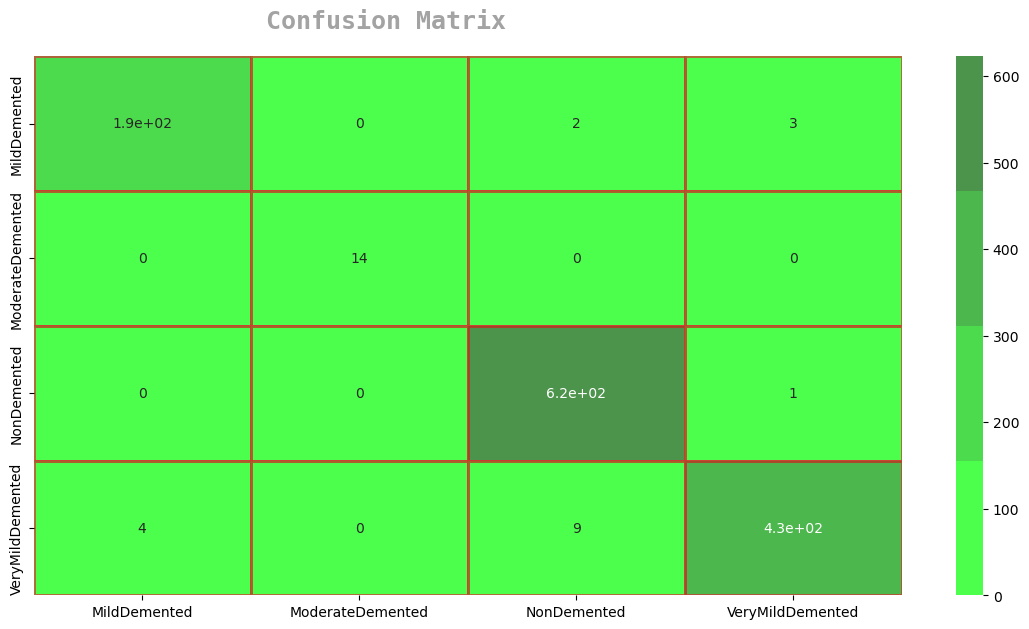

Accuracy: 98.52%


In [14]:
#testinng 
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)

y_test_new = np.argmax(y_test, axis=1)

# Ensure y_test_new and pred have the same number of samples
y_test_new = y_test_new[:len(pred)]

print(classification_report(y_test_new, pred))
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(confusion_matrix(y_test_new, pred), ax=ax, xticklabels=labels, yticklabels=labels, annot=True, cmap=colors_green[::1], alpha=0.7, linewidths=2, linecolor=colors_dark[3])
fig.text(s=' Confusion Matrix', size=18, fontweight='bold', fontname='monospace', color=colors_dark[1], y=0.92, x=0.28, alpha=0.8)

plt.show()

accuracy = np.sum(pred == y_test_new) / len(pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))


In [15]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from ipywidgets import widgets


# Define the directories for training and testing data
train_dir = os.path.join(r'/Users/saikeerthana/Downloads/Alzheimer_sDataset','train')
test_dir = os.path.join(r'/Users/saikeerthana/Downloads/Alzheimer_sDataset/test')

# Load the training and testing data
train_data = image_dataset_from_directory(train_dir, image_size=(150,150), label_mode="categorical", batch_size=32)
test_data = image_dataset_from_directory(test_dir, image_size=(150,150), label_mode="categorical", batch_size=32)

# Function to predict image and show result
def img_pred(upload):
    for name,file_info in upload.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
        display(img)
        opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        img = cv2.resize(opencvImage, (150,150))
        img = np.expand_dims(img, axis=0)
        pred = model.predict(img)
        pred_label = np.argmax(pred, axis=1)[0]
        if pred_label == 0:
            pred_text = 'Mild Demented'
        elif pred_label == 1:
            pred_text = 'Moderate Demented'
        elif pred_label == 2:
            pred_text = 'Non Demented'
        else:
            pred_text = 'Very Mild Demented'
        print(f'The model predicts that it is a {pred_text}')
        height,width, channels=150,150,3
        print(f'Prediction from CNN:{pred_text}')
        perturbations = generate_adversary(img, pred).numpy()
        adversarial = img + (perturbations * 0.5)
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
        ax1.imshow(img[0].reshape(150,150,3))
        ax1.set_title("Original Image")
        ax2.imshow(adversarial[0])
        ax2.set_title("Image with Adversary")
        plt.show()

# Function to generate an adversarial image
def generate_adversary(image, label):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image) 
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
        gradient = tape.gradient(loss, image)
        sign_grad = tf.sign(gradient)
    return sign_grad

# Create file upload widget and button for prediction
uploader = widgets.FileUpload()
display(uploader)
button = widgets.Button(description='Predict')
out = widgets.Output()

# Define the function to run on button click
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
        except:
            print('No Image Uploaded/Invalid Image File')

# Attach function to button click event
button.on_click(on_button_clicked)

# Display the button and output widget
widgets.VBox([button, out])


Found 5121 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


FileUpload(value=(), description='Upload')

In [16]:
from random import randint

def adversary_generator(batch_size):
    while True:
        images=[]
        labels=[]
        for batch in range(batch_size):
            height,width, channels=150,150,3
            N = randint(0, len(X_train) - 1)

            label=y_train[N]
            image=X_train[N].reshape((1,height,width,channels))
            perturbations= generate_adversary(image, label).numpy()
            adversarial=image+(perturbations*0.1)
            images.append(adversarial)
            labels.append(label
                         )
#             if batch%100==0:
#                 print(f"{batch} images generated")
        images= np.asarray(images).reshape((batch_size, height, width, channels))
        labels= np.asarray(labels)
        yield images,labels
x_adversarial, y_adversarial= next(adversary_generator(500))
ad_acc = model.evaluate(x_adversarial, y_adversarial, verbose=0)


model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
reduce_lr=ReduceLROnPlateau(monitor='val_accuracy',factor=0.2,patience=2,min_delta= 0.001,mode='auto',verbose=1)
checkpoint=ModelCheckpoint("alzheimers-dataset-4-class-of images.h1", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
history=model.fit(x_adversarial, y_adversarial,validation_split=0.2, epochs=15, verbose=1,batch_size=32,callbacks=[tensorboard,checkpoint,reduce_lr])

pred1= model.predict(x_adversarial)
pred1 = np.argmax(pred1,axis=1)
y_test_new = np.argmax(y_adversarial,axis=1)
print(classification_report(y_test_new,pred1))

accuracy1 = np.sum(pred1 == y_test_new) / len(pred1)
print("Accuracy: {:.2f}%".format(accuracy1 * 100))


Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 1.0212 - accuracy: 0.7625
Epoch 1: val_accuracy improved from -inf to 0.85000, saving model to alzheimers-dataset-4-class-of images.h1
INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


13/13 [==============================] - 22s 2s/step - loss: 1.0212 - accuracy: 0.7625 - val_loss: 0.3819 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.9600
Epoch 2: val_accuracy did not improve from 0.85000
13/13 [==============================] - 12s 865ms/step - loss: 0.1350 - accuracy: 0.9600 - val_loss: 0.4792 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9975
Epoch 3: val_accuracy did not improve from 0.85000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
13/13 [==============================] - 11s 819ms/step - loss: 0.0466 - accuracy: 0.9975 - val_loss: 0.6089 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/15
13/13 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9925
Epoch 4: val_accuracy improved from 0.85000 to 0.87000, saving model to alzheimers-dataset-4-class-of imag

INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


13/13 [==============================] - 19s 2s/step - loss: 0.0374 - accuracy: 0.9925 - val_loss: 0.4156 - val_accuracy: 0.8700 - lr: 2.0000e-04
Epoch 5/15
13/13 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9925
Epoch 5: val_accuracy improved from 0.87000 to 0.90000, saving model to alzheimers-dataset-4-class-of images.h1
INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


13/13 [==============================] - 20s 2s/step - loss: 0.0292 - accuracy: 0.9925 - val_loss: 0.2743 - val_accuracy: 0.9000 - lr: 2.0000e-04
Epoch 6/15
13/13 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9950
Epoch 6: val_accuracy improved from 0.90000 to 0.91000, saving model to alzheimers-dataset-4-class-of images.h1
INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


13/13 [==============================] - 19s 1s/step - loss: 0.0248 - accuracy: 0.9950 - val_loss: 0.2301 - val_accuracy: 0.9100 - lr: 2.0000e-04
Epoch 7/15
13/13 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 1.0000
Epoch 7: val_accuracy improved from 0.91000 to 0.93000, saving model to alzheimers-dataset-4-class-of images.h1
INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


13/13 [==============================] - 20s 2s/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.1937 - val_accuracy: 0.9300 - lr: 2.0000e-04
Epoch 8/15
13/13 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 1.0000
Epoch 8: val_accuracy did not improve from 0.93000
13/13 [==============================] - 16s 1s/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.1724 - val_accuracy: 0.9300 - lr: 2.0000e-04
Epoch 9/15
13/13 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9950
Epoch 9: val_accuracy improved from 0.93000 to 0.94000, saving model to alzheimers-dataset-4-class-of images.h1
INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


13/13 [==============================] - 22s 2s/step - loss: 0.0158 - accuracy: 0.9950 - val_loss: 0.1551 - val_accuracy: 0.9400 - lr: 2.0000e-04
Epoch 10/15
13/13 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9975
Epoch 10: val_accuracy improved from 0.94000 to 0.95000, saving model to alzheimers-dataset-4-class-of images.h1
INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


13/13 [==============================] - 20s 2s/step - loss: 0.0111 - accuracy: 0.9975 - val_loss: 0.1498 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 11/15
13/13 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 1.0000
Epoch 11: val_accuracy did not improve from 0.95000
13/13 [==============================] - 13s 886ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.1420 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 12/15
13/13 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 1.0000
Epoch 12: val_accuracy did not improve from 0.95000

Epoch 12: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
13/13 [==============================] - 12s 938ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.1385 - val_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 13/15
13/13 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9975
Epoch 13: val_accuracy improved from 0.95000 to 0.96000, saving model to alzheimers-data

INFO:tensorflow:Assets written to: alzheimers-dataset-4-class-of images.h1/assets


13/13 [==============================] - 20s 2s/step - loss: 0.0115 - accuracy: 0.9975 - val_loss: 0.1335 - val_accuracy: 0.9600 - lr: 4.0000e-05
Epoch 14/15
13/13 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000
Epoch 14: val_accuracy did not improve from 0.96000
13/13 [==============================] - 15s 1s/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.1298 - val_accuracy: 0.9600 - lr: 4.0000e-05
Epoch 15/15
13/13 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9975
Epoch 15: val_accuracy did not improve from 0.96000

Epoch 15: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
16/16 [==============================] - 3s 170ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00         5
           2       0.99      0.99      0.99       247
           3       0.99      0.99      0.99       184

    accur